# Conservation and stability test for triangles

In [1]:
using StableSpectralElements, OrdinaryDiffEq, Plots, LaTeXStrings, JLD2

In [2]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0

conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ)))
initial_data = InitialDataCosine(A,k)
exact_solution = ExactSolution(conservation_law,initial_data);

In [3]:
M = 2
p = 4
upwind = StandardForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(1.0))
central = StandardForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(0.0))
ode_algorithm = CarpenterKennedy2N54();

In [4]:
nodal = ReferenceApproximation(
    NodalTensor(p), Tri(), mapping_degree=3)
modal = ReferenceApproximation(
    ModalTensor(p), Tri(), mapping_degree=3)

mesh = warp_mesh(uniform_periodic_mesh(
    nodal.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), collapsed_orientation=true), 
    nodal.reference_element, 
    ChanWarping(1.0/16.0,(L,L)))

spatial_discretization_nodal = SpatialDiscretization(mesh, 
     nodal, project_jacobian=false)

spatial_discretization_modal = SpatialDiscretization(mesh, 
     modal, project_jacobian=true)

results_path_nodal_upwind = save_project(conservation_law,
     spatial_discretization_nodal, initial_data, upwind, (0.0, T),
    "../results/stability_conservation/advection_2d_nodal_upwind/", overwrite=true, clear=true)

results_path_nodal_central = save_project(conservation_law,
     spatial_discretization_nodal, initial_data, central, (0.0, T),
    "../results/stability_conservation/advection_2d_nodal_central/", overwrite=true, clear=true)

results_path_modal_upwind = save_project(conservation_law,
     spatial_discretization_modal, initial_data, upwind, (0.0, T),
    "../results/stability_conservation/advection_2d_modal_upwind/", overwrite=true, clear=true)

results_path_modal_central = save_project(conservation_law,
     spatial_discretization_modal, initial_data, central, (0.0, T),
    "../results/stability_conservation/advection_2d_modal_central/", overwrite=true, clear=true)

"../results/stability_conservation/advection_2d_modal_central/"

In [5]:
ode_problem_nodal_upwind = semidiscretize(conservation_law,
    spatial_discretization_nodal,
    initial_data, 
    upwind,
    (0.0, T),
    PhysicalOperator(),
    mass_matrix_solver=WeightAdjustedSolver(spatial_discretization_nodal))

ode_problem_nodal_central = semidiscretize(conservation_law,
    spatial_discretization_nodal,
    initial_data, 
    central,
    (0.0, T),
    PhysicalOperator(),
    mass_matrix_solver=WeightAdjustedSolver(spatial_discretization_nodal))

ode_problem_modal_upwind = semidiscretize(conservation_law,
    spatial_discretization_modal,
    initial_data, 
    upwind,
    (0.0, T),
    PhysicalOperator(),
    mass_matrix_solver=WeightAdjustedSolver(spatial_discretization_modal))

ode_problem_modal_central = semidiscretize(conservation_law,
    spatial_discretization_modal,
    initial_data, 
    central,
    (0.0, T),
    PhysicalOperator(),
    mass_matrix_solver=WeightAdjustedSolver(spatial_discretization_modal))

dt = T/5600

0.00017857142857142857

In [6]:
sol_nodal_upwind = solve(ode_problem_nodal_upwind, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path_nodal_upwind, (0.0,T), 56));

In [7]:
sol_nodal_central = solve(ode_problem_nodal_central, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path_nodal_central, (0.0,T), 56));

In [8]:
sol_modal_upwind = solve(ode_problem_modal_upwind, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path_modal_upwind, (0.0,T), 56));

In [9]:
sol_modal_central = solve(ode_problem_modal_central, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path_modal_central, (0.0,T), 56));

In [10]:
conservation_upwind_modal = analyze(PrimaryConservationAnalysis(results_path_modal_upwind, 
    conservation_law, spatial_discretization_modal), load_time_steps(results_path_modal_upwind))
energy_upwind_modal =analyze(EnergyConservationAnalysis(results_path_modal_upwind, 
    conservation_law, spatial_discretization_modal), load_time_steps(results_path_modal_upwind))
conservation_central_modal = analyze(PrimaryConservationAnalysis(results_path_modal_central, 
    conservation_law, spatial_discretization_modal), load_time_steps(results_path_modal_central))
energy_central_modal = analyze(EnergyConservationAnalysis(results_path_modal_central, 
    conservation_law, spatial_discretization_modal), load_time_steps(results_path_modal_central));

In [11]:
conservation_upwind_nodal = analyze(PrimaryConservationAnalysis(results_path_nodal_upwind, 
    conservation_law, spatial_discretization_nodal), load_time_steps(results_path_nodal_upwind))
energy_upwind_nodal =analyze(EnergyConservationAnalysis(results_path_nodal_upwind, 
    conservation_law, spatial_discretization_nodal), load_time_steps(results_path_nodal_upwind))
conservation_central_nodal = analyze(PrimaryConservationAnalysis(results_path_nodal_central, 
    conservation_law, spatial_discretization_nodal), load_time_steps(results_path_nodal_central))
energy_central_nodal = analyze(EnergyConservationAnalysis(results_path_nodal_central, 
    conservation_law, spatial_discretization_nodal), load_time_steps(results_path_nodal_central));

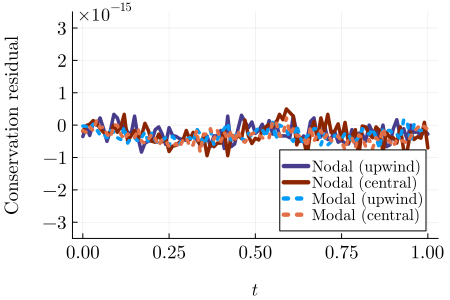

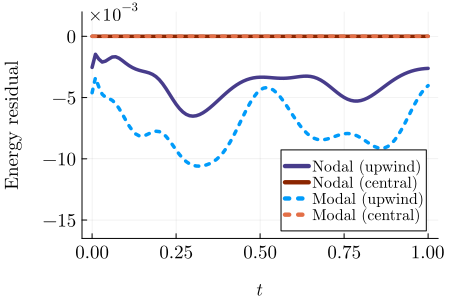

In [12]:
cons = plot(xlabel="\n\$t\$", ylabel="Conservation residual\n", fontfamily="Computer Modern", legend=:bottomright,
    legendfontsize=10, xguidefontsize=12, yguidefontsize=12, ylims=[-3.5,3.5],
    #yticks=([-5e-15, -5e-16, 0, 5e-16, 1e-15], [L"-1.0", L"-0.5", L"0", L"0.5", L"1.0"] ),
    xtickfontsize=12, ytickfontsize=12, size=(450,300))
energy = plot(xlabel="\n\$t\$", ylabel="Energy residual\n", fontfamily="Computer Modern", legend=:bottomright,
    legendfontsize=10, xguidefontsize=12, yguidefontsize=12, xtickfontsize=12, ytickfontsize=12,
    ylims=[-16.5,2.0], size=(450,300)) 

plot!(cons, conservation_upwind_nodal.t, 1.0e15*(conservation_upwind_nodal.dEdt), 
    label="Nodal (upwind)", linewidth=3.5, color=:slateblue4)
plot!(cons, conservation_central_nodal.t, 1.0e15*(conservation_central_nodal.dEdt), 
    label="Nodal (central)", linewidth=3.5, color=:orangered4)
plot!(energy, energy_upwind_nodal.t, 1.0e3*(energy_upwind_nodal.dEdt), 
    label="Nodal (upwind)", linewidth=3.5, color=:slateblue4)
plot!(energy, energy_central_nodal.t, 1.0e3*energy_central_nodal.dEdt,
      label="Nodal (central)", linewidth=3.5, color=:orangered4)
plot!(cons, conservation_upwind_modal.t, 1.0e15*(conservation_upwind_modal.dEdt), 
    linewidth=3.5, color=palette(:default)[1], label="Modal (upwind)", linestyle=:dot)
plot!(cons, conservation_central_modal.t, 1.0e15*(conservation_central_modal.dEdt), 
    linewidth=3.5, color=palette(:default)[2], label="Modal (central)", linestyle=:dot)
plot!(energy, energy_upwind_modal.t, 1.0e3*energy_upwind_modal.dEdt, label="Modal (upwind)",
    linewidth=3.5, color=palette(:default)[1], linestyle=:dot)
plot!(energy, energy_central_modal.t, 1.0e3*energy_central_modal.dEdt, label="Modal (central)",
    linewidth=3.5, color=palette(:default)[2], linestyle=:dot)
annotate!(cons,[(0.07, 3.5, Plots.text(L"\times\, 10^{-15}", 12, :black, :center))])
annotate!(energy,[(0.07, 2.0, Plots.text(L"\times\, 10^{-3}", 12, :black, :center))])
display(cons)
display(energy)

In [13]:
savefig(cons, "../plots/conservation_stability/conservation_tri.pdf")
savefig(energy, "../plots/conservation_stability/energy_tri.pdf")

"/Users/tristanmontoya/Research/ReproduceSBPSimplex/plots/conservation_stability/energy_tri.pdf"